<a href="https://colab.research.google.com/github/SeyfGoumeida/Projet_Mixt_Coclus_Partie1/blob/main/Projet_Mixt_Coclus_Partie1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#!pip install nltk
#!pip install gensim

In [1]:
import pandas as pd
import string
import re
import operator
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
#------------------------------------------------ 
import os
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re
import operator
from functools import reduce
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim.utils import tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
#from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('/content/classic4.csv',header=0,index_col=0)
df

,text,label
0,Computer-Aided Analysis and Design of Informat...,cacm
1,Milestones in Cataloging In the case of the pr...,cisi
2,childhood psychosis. a description is given of...,med
3,neonatal hepatitis or familial neonatal obstru...,med
4,Handbook of Comparative Librarianship The firs...,cisi
...,...,...
7090,throat and nose surgery in patients with const...,med
7091,Computers and Society: A Proposed Course for C...,cacm
7092,Romberg Integration (Algorithm 60),cacm
7093,Semantic Evaluation from Left to Right This pa...,cacm


In [4]:
df["label"].value_counts().to_frame()

,label
cacm,3204
cisi,1460
cran,1398
med,1033


In [5]:
#punctuations
punctuations = string.punctuation
#stopwords
stop_words = list(STOP_WORDS)
def clean_text(
  string : str,
  ponctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
  stop_words = stop_words)->str : 

  #URLs
  string = re.sub(r"https?://\S+|www\.\S+",'',string)
  #html 
  string = re.sub(r'<.*?>','',string)
  #Numbers
  string = re.sub(r'[0-9]+','',string) 

  #Remove punctuations
  for x in string.lower():
    if x in punctuations:
      string = string.replace(x,"")
  #To lower
  string = string.lower()
  #Remove stop words
  lemmatizer = WordNetLemmatizer()
  string = ' '.join([lemmatizer.lemmatize(word) for word in string.split() if word not in stop_words])
  #Cleaning the whitespaces
  string = re.sub(r'\s', ' ', string).strip()

  return string

In [6]:
abstract = df['text'].to_list()
abstracts_cleaned = [clean_text(x) for x in abstract]

In [7]:
len(abstracts_cleaned)

7095

## **Word2Vec :**

### **Document embedding :**

In [8]:
true_labels, u  = pd.factorize(df['label'])
sentances = [list(tokenize(s, deacc=True, lower=True)) for s in abstracts_cleaned]
len(sentances)

7095

In [9]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

--2021-12-03 20:07:40--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.66.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.66.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  50.4MB/s    in 27s     

2021-12-03 20:08:07 (58.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [10]:
# Load Google's pre-trained Word2Vec model.
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [15]:
#from gensim.models import KeyedVectors

#model_2 = Word2Vec(size=300, min_count=1)
#model_2.build_vocab(sentances)
#total_examples = model_2.corpus_count
#model = KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True)
#model_2.intersect_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
#model_2.train(sentances, total_examples=total_examples, epochs=model_2.iter)

In [12]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(sentances, model=model)
len(vectorized_docs), len(vectorized_docs[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(7095, 300)

### **Réduction de la dimension :**

In [12]:
reduced_data = {}
reduced_data['original'] = vectorized_docs

#### **PCA** :

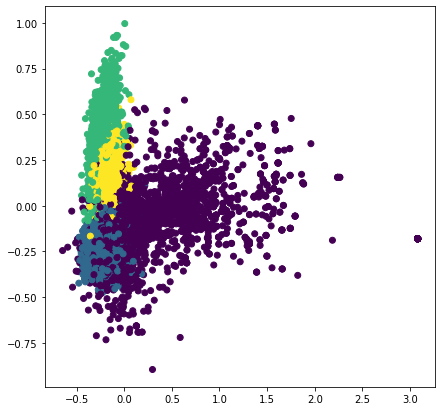

In [13]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(vectorized_docs)
reduced_data["PCA"] = pca_components

#---------------plot----------------------------------

f = plt.figure(figsize=(7,7))
PCA_components = pd.DataFrame(pca_components)
plt.scatter(PCA_components[0], PCA_components[1],c=true_labels)
plt.show()

#### **T-SNE :**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


tsne init = 'pca'


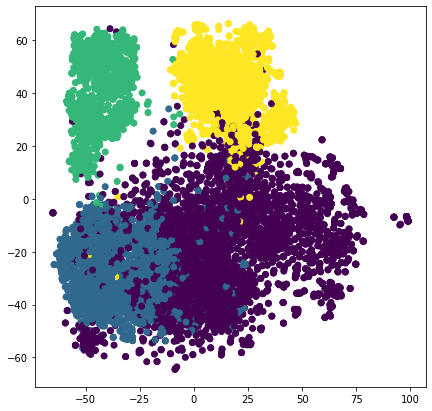

In [14]:
tsne_components = TSNE(n_components=2,init='pca').fit_transform(vectorized_docs)
reduced_data["TSNE"] = tsne_components

#------------------plot-----------------

f = plt.figure(figsize=(7,7))
print("tsne init = 'pca'")
TSNE_components = pd.DataFrame(tsne_components) #tsne with inti ='pca'
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **UMAP :**

In [16]:
!pip install umap-learn
import umap

     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 33.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=cd170125dfceb98e239ad12a278a0beaec7faca4742caa7a6333362fe326d3d5
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=ff6e9631e07a0bd8ab87a62d7599dd8ec483ac71075483f415bb37dcdf85fa66
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


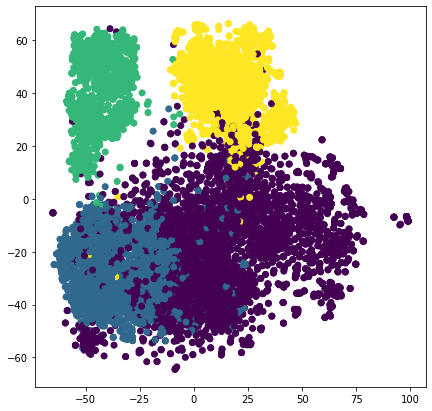

In [17]:
reducer = umap.UMAP()
umap_components = reducer.fit_transform(vectorized_docs)
reduced_data["UMAP"] = umap_components
umap_components.shape

#----------------plot---------------------
f = plt.figure(figsize=(7,7))
UMAP_components = pd.DataFrame(umap_components) 
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **Autoencoders :**

In [99]:
#Pas encore

### **Clustering :**

#### **K-means :**

original  Data
plot with predicted labels


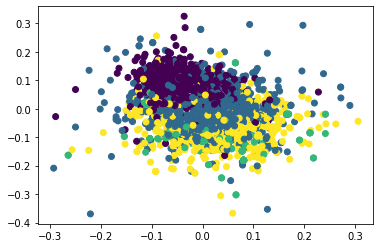

plot with true labels


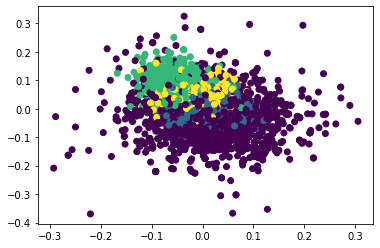

Word2vec : Kmeans clustering on  original  data accuracy :  0.21902748414376322
Word2vec : Kmeans clustering on  original  data NMI :  0.4851712208557278
Word2vec : Kmeans clustering on  original  data ARI :  0.3222797582704375
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


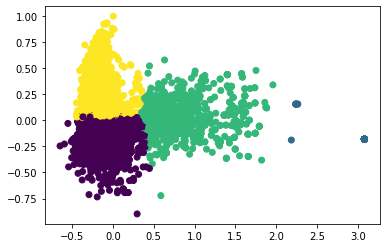

plot with true labels


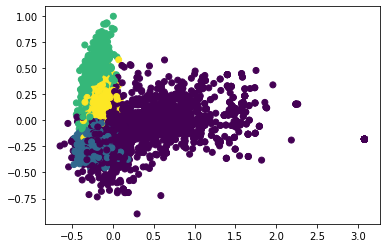

Word2vec : Kmeans clustering on  PCA  data accuracy :  0.47864693446088796
Word2vec : Kmeans clustering on  PCA  data NMI :  0.4646520846836809
Word2vec : Kmeans clustering on  PCA  data ARI :  0.3161765199370398
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


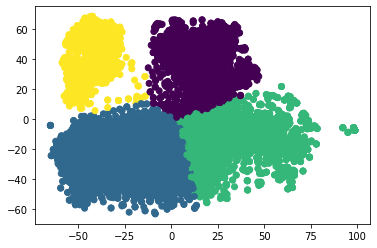

plot with true labels


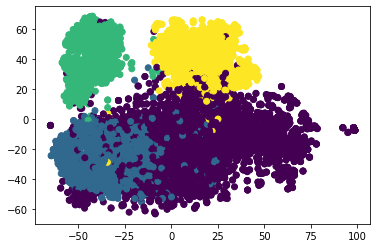

Word2vec : Kmeans clustering on  TSNE  data accuracy :  0.23608174770965468
Word2vec : Kmeans clustering on  TSNE  data NMI :  0.6542651915336575
Word2vec : Kmeans clustering on  TSNE  data ARI :  0.51296562676555
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


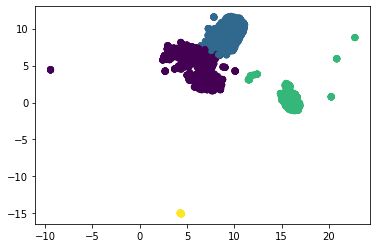

plot with true labels


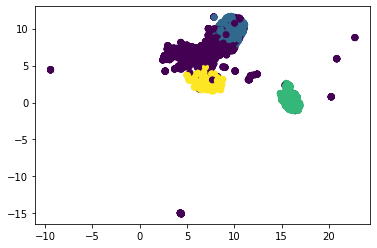

Word2vec : Kmeans clustering on  UMAP  data accuracy :  0.55461592670895
Word2vec : Kmeans clustering on  UMAP  data NMI :  0.5352825300494851
Word2vec : Kmeans clustering on  UMAP  data ARI :  0.3497195719747142
________________________________________________________________________________________________________


In [32]:
def kmeans_runner(key,K,true_labels):
  kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(reduced_data[key])
  y_pred = kmeans.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()

  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : Kmeans clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : Kmeans clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : Kmeans clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")


K = 4
for a in reduced_data.keys():
  kmeans_runner(a,K,true_labels)

#### **Spectral clustering :**

original  Data
plot with predicted labels


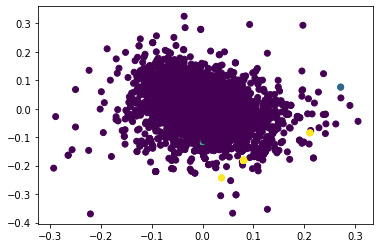

plot with true labels


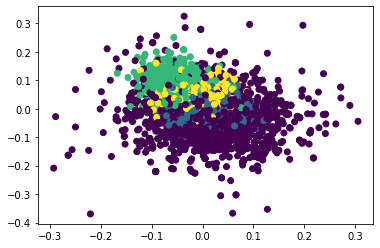

Word2vec : spectral clustering on  original  data accuracy :  0.44200140944326993
Word2vec : spectral clustering on  original  data NMI :  0.011432439464275107
Word2vec : spectral clustering on  original  data ARI :  -0.007784530943189727
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


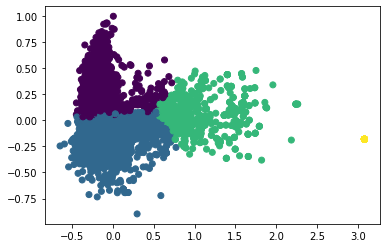

plot with true labels


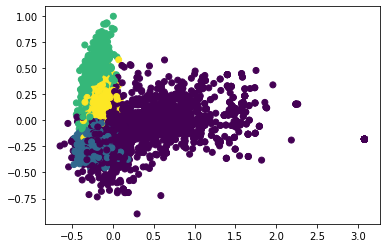

Word2vec : spectral clustering on  PCA  data accuracy :  0.23255813953488372
Word2vec : spectral clustering on  PCA  data NMI :  0.44871444007371325
Word2vec : spectral clustering on  PCA  data ARI :  0.3210521050916887
________________________________________________________________________________________________________


KeyboardInterrupt: ignored

In [36]:
def spec_clust_runner(key,K,true_labels):

  spectral_clust = SpectralClustering(n_clusters=K,assign_labels='discretize',random_state=0).fit(reduced_data[key])
  y_pred = spectral_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : spectral clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : spectral clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : spectral clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  spec_clust_runner(a,K,true_labels)

#### **HDBSCAN :**

In [18]:
!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311877 sha256=6504a9ff0a31f1dcb093e74ae0a5ebf0f22fd86e9b1991930d5c441d5384e56a
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


original  Data
plot with predicted labels


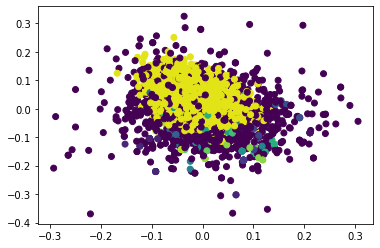

plot with true labels


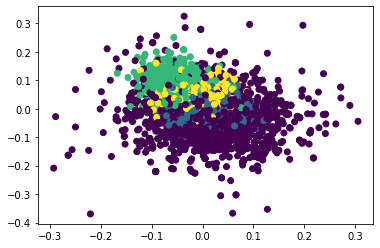

Word2vec : hdbscan clustering on  original  data accuracy :  0.0007047216349541931
Word2vec : hdbscan clustering on  original  data NMI :  0.1699980311035043
Word2vec : hdbscan clustering on  original  data ARI :  -0.01592381356670689
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


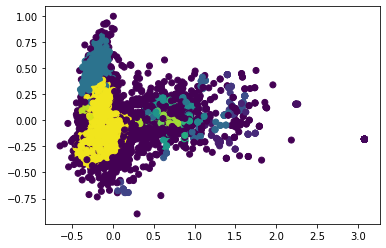

plot with true labels


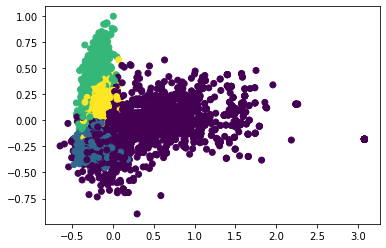

Word2vec : hdbscan clustering on  PCA  data accuracy :  0.007470049330514447
Word2vec : hdbscan clustering on  PCA  data NMI :  0.33658693994351424
Word2vec : hdbscan clustering on  PCA  data ARI :  0.14016475310295898
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


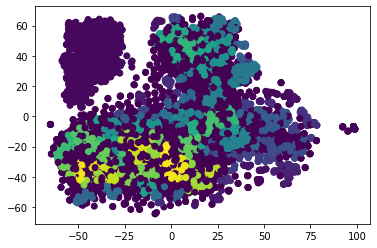

plot with true labels


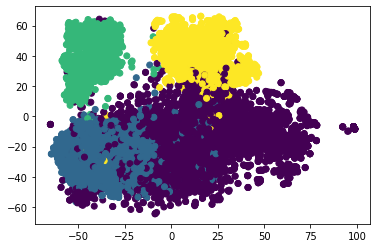

Word2vec : hdbscan clustering on  TSNE  data accuracy :  0.0007047216349541931
Word2vec : hdbscan clustering on  TSNE  data NMI :  0.34576431078285474
Word2vec : hdbscan clustering on  TSNE  data ARI :  0.1464789282061772
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


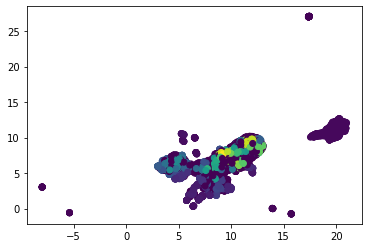

plot with true labels


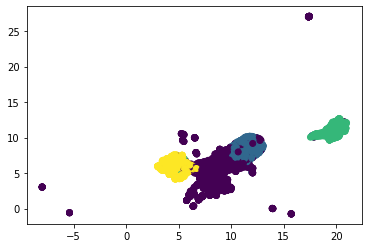

Word2vec : hdbscan clustering on  UMAP  data accuracy :  0.007610993657505285
Word2vec : hdbscan clustering on  UMAP  data NMI :  0.33877408099013945
Word2vec : hdbscan clustering on  UMAP  data ARI :  0.1361209430823059
________________________________________________________________________________________________________


In [23]:
def hdbscan_runner(key,true_labels):
  hdbscan_clust = hdbscan.HDBSCAN().fit(reduced_data[key])
  y_pred = hdbscan_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : hdbscan clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : hdbscan clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : hdbscan clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  hdbscan_runner(a,true_labels)

#### **CAH :**

original  Data
plot with predicted labels


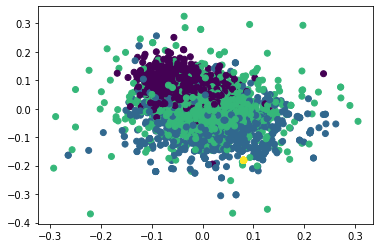

plot with true labels


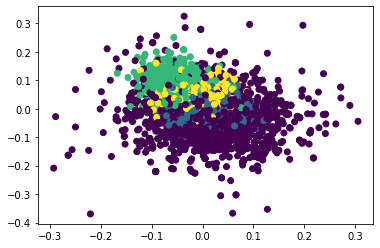

Word2vec : cah clustering on  original  data accuracy :  0.0204369274136716
Word2vec : cah clustering on  original  data NMI :  0.5236524088999778
Word2vec : cah clustering on  original  data ARI :  0.3531278774686336
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


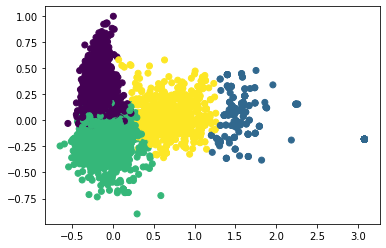

plot with true labels


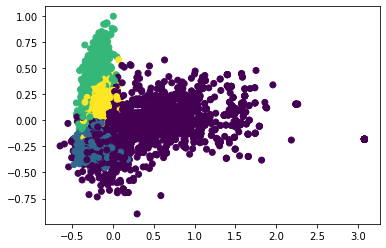

Word2vec : cah clustering on  PCA  data accuracy :  0.025933756166314305
Word2vec : cah clustering on  PCA  data NMI :  0.4580408758233036
Word2vec : cah clustering on  PCA  data ARI :  0.30437935905103186
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


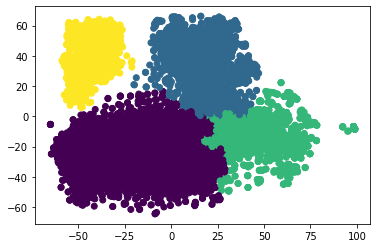

plot with true labels


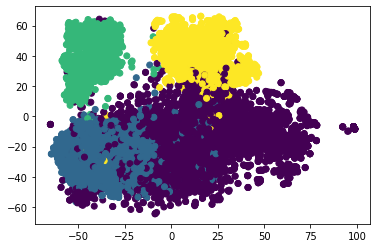

Word2vec : cah clustering on  TSNE  data accuracy :  0.23650458069062721
Word2vec : cah clustering on  TSNE  data NMI :  0.642543872112887
Word2vec : cah clustering on  TSNE  data ARI :  0.44086919565246324
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


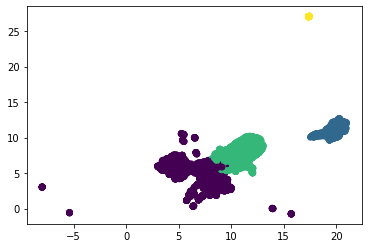

plot with true labels


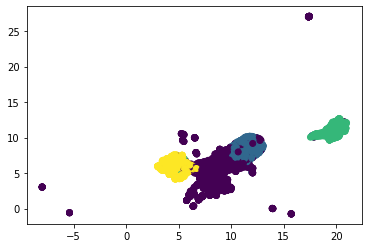

Word2vec : cah clustering on  UMAP  data accuracy :  0.2328400281888654
Word2vec : cah clustering on  UMAP  data NMI :  0.566682845917992
Word2vec : cah clustering on  UMAP  data ARI :  0.3626444363334974
________________________________________________________________________________________________________


In [25]:
def cah_runner(key,K,true_labels):
  y_pred = AgglomerativeClustering(n_clusters = K).fit_predict(reduced_data[key])
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : cah clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : cah clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : cah clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  cah_runner(a,K,true_labels)

In [ ]:
del()

# **Glove :**

In [9]:
!wget -c "https://nlp.stanford.edu/data/glove.840B.300d.zip"
!unzip glove*.zip

--2021-12-03 22:05:36--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-12-03 22:05:36--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G   761KB/s    in 43m 14s 

2021-12-03 22:48:51 (819 KB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     

In [10]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath("/content/glove.840B.300d.txt")
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

In [13]:
vectorized_docs = vectorize(sentances, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(7095, 300)

In [14]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df:  5.6 MiB
                            _3:  5.6 MiB
             abstracts_cleaned: 60.0 KiB
                     sentances: 60.0 KiB
               vectorized_docs: 60.0 KiB
                      abstract: 55.5 KiB
                    STOP_WORDS: 32.2 KiB
                    stop_words:  3.0 KiB
                           _i1:  1.3 KiB
             WordNetLemmatizer:  1.0 KiB


### **Réduction de la dimension :**

In [15]:
reduced_data = {}
reduced_data['original'] = vectorized_docs

#### **PCA** :

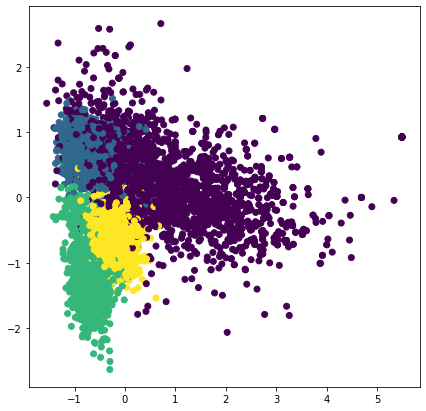

In [16]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(vectorized_docs)
reduced_data["PCA"] = pca_components

#---------------plot----------------------------------

f = plt.figure(figsize=(7,7))
PCA_components = pd.DataFrame(pca_components)
plt.scatter(PCA_components[0], PCA_components[1],c=true_labels)
plt.show()

#### **T-SNE :**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


tsne init = 'pca'


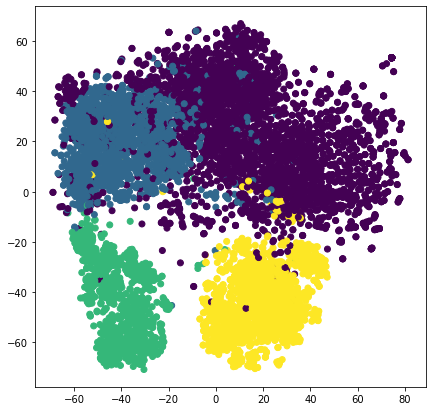

In [17]:
tsne_components = TSNE(n_components=2,init='pca').fit_transform(vectorized_docs)
reduced_data["TSNE"] = tsne_components

#------------------plot-----------------

f = plt.figure(figsize=(7,7))
print("tsne init = 'pca'")
TSNE_components = pd.DataFrame(tsne_components) #tsne with inti ='pca'
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **UMAP :**

In [18]:
!pip install umap-learn
import umap

     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=144ea505d00b31c4fca94e315a735b93984cf82353ddf7e3e530c3ac46a27c30
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=e789b44a22b92a1c0e1d6075debe0f8bfbcce8b4baab4ff15cbe77488c20425c
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


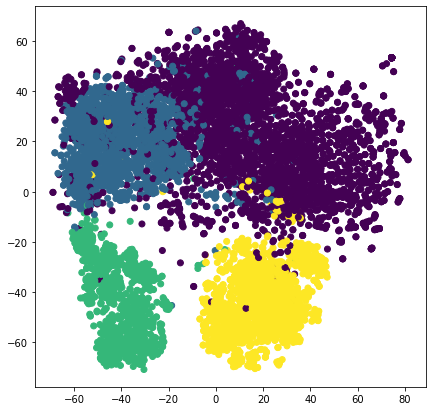

In [19]:
reducer = umap.UMAP()
umap_components = reducer.fit_transform(vectorized_docs)
reduced_data["UMAP"] = umap_components
umap_components.shape

#----------------plot---------------------
f = plt.figure(figsize=(7,7))
UMAP_components = pd.DataFrame(umap_components) 
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **Autoencoders :**

In [20]:
#Pas encore

### **Clustering :**

#### **K-means :**

original  Data
plot with predicted labels


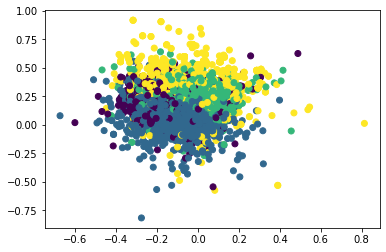

plot with true labels


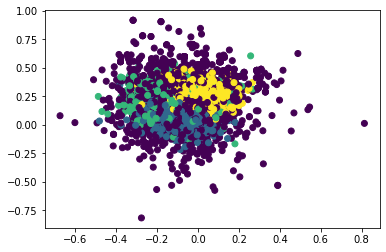

Glove : Kmeans clustering on  original  data accuracy :  0.20972515856236787
Glove : Kmeans clustering on  original  data NMI :  0.6025921010215153
Glove : Kmeans clustering on  original  data ARI :  0.41497694748423813
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


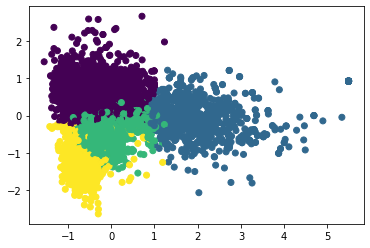

plot with true labels


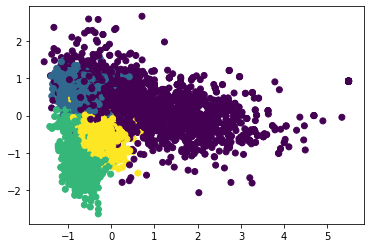

Glove : Kmeans clustering on  PCA  data accuracy :  0.2613107822410148
Glove : Kmeans clustering on  PCA  data NMI :  0.5698095859436703
Glove : Kmeans clustering on  PCA  data ARI :  0.3921485370495791
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


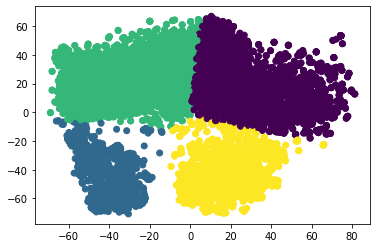

plot with true labels


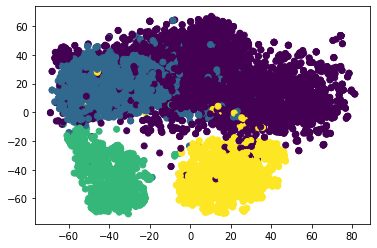

Glove : Kmeans clustering on  TSNE  data accuracy :  0.4979563072586328
Glove : Kmeans clustering on  TSNE  data NMI :  0.6868177608043312
Glove : Kmeans clustering on  TSNE  data ARI :  0.5907926174449839
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


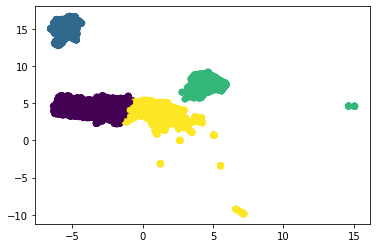

plot with true labels


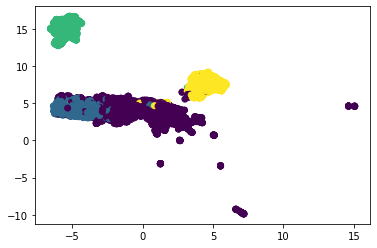

Glove : Kmeans clustering on  UMAP  data accuracy :  0.21550387596899226
Glove : Kmeans clustering on  UMAP  data NMI :  0.6962358959872652
Glove : Kmeans clustering on  UMAP  data ARI :  0.5157659256175946
________________________________________________________________________________________________________


In [21]:
def kmeans_runner(key,K,true_labels):
  kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(reduced_data[key])
  y_pred = kmeans.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()

  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : Kmeans clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : Kmeans clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : Kmeans clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")


K = 4
for a in reduced_data.keys():
  kmeans_runner(a,K,true_labels)

#### **Spectral clustering :**

original  Data
plot with predicted labels


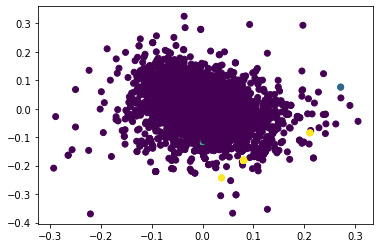

plot with true labels


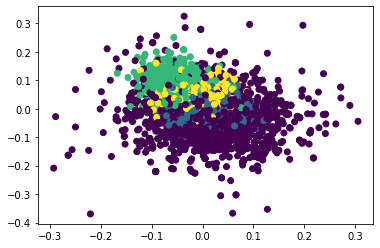

Word2vec : spectral clustering on  original  data accuracy :  0.44200140944326993
Word2vec : spectral clustering on  original  data NMI :  0.011432439464275107
Word2vec : spectral clustering on  original  data ARI :  -0.007784530943189727
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


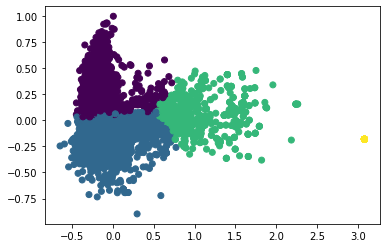

plot with true labels


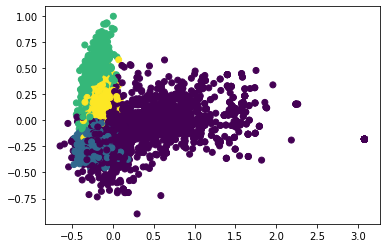

Word2vec : spectral clustering on  PCA  data accuracy :  0.23255813953488372
Word2vec : spectral clustering on  PCA  data NMI :  0.44871444007371325
Word2vec : spectral clustering on  PCA  data ARI :  0.3210521050916887
________________________________________________________________________________________________________


KeyboardInterrupt: ignored

In [ ]:
def spec_clust_runner(key,K,true_labels):

  spectral_clust = SpectralClustering(n_clusters=K,assign_labels='discretize',random_state=0).fit(reduced_data[key])
  y_pred = spectral_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : spectral clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : spectral clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : spectral clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  spec_clust_runner(a,K,true_labels)

#### **HDBSCAN :**

In [22]:
!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4 MB 9.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311925 sha256=8f148e8409db4d6c02e6cbccbaf8cea0da850a2e9abd284fdae71e4d132399b5
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


original  Data
plot with predicted labels


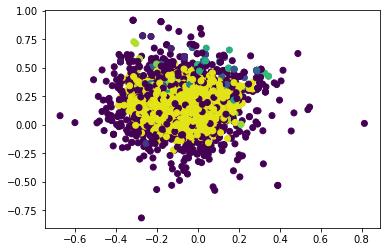

plot with true labels


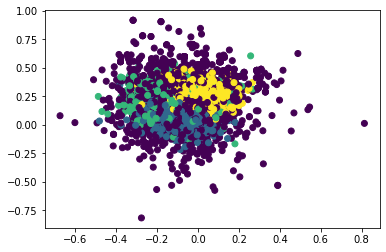

Glove : hdbscan clustering on  original  data accuracy :  0.0007047216349541931
Glove : hdbscan clustering on  original  data NMI :  0.16398652529986674
Glove : hdbscan clustering on  original  data ARI :  -0.00944271344518929
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


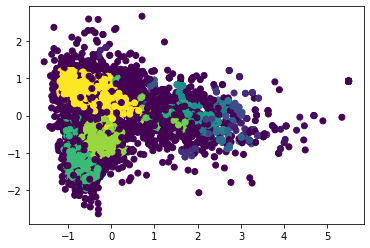

plot with true labels


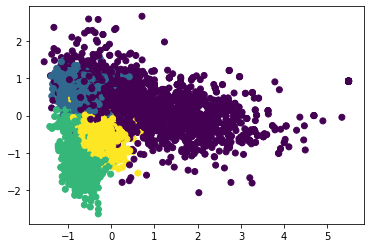

Glove : hdbscan clustering on  PCA  data accuracy :  0.006060606060606061
Glove : hdbscan clustering on  PCA  data NMI :  0.41793520601635764
Glove : hdbscan clustering on  PCA  data ARI :  0.26408377442984005
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


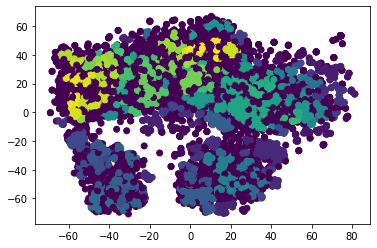

plot with true labels


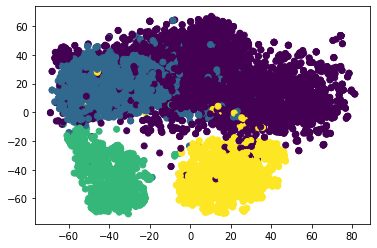

Glove : hdbscan clustering on  TSNE  data accuracy :  0.00817477096546864
Glove : hdbscan clustering on  TSNE  data NMI :  0.2923300621749139
Glove : hdbscan clustering on  TSNE  data ARI :  0.03303322913494231
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


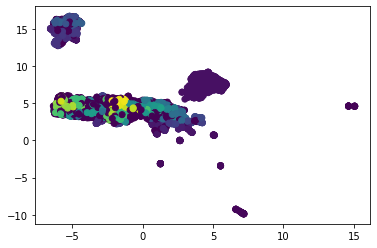

plot with true labels


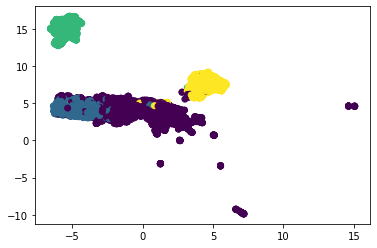

Glove : hdbscan clustering on  UMAP  data accuracy :  0.001127554615926709
Glove : hdbscan clustering on  UMAP  data NMI :  0.36863754985709996
Glove : hdbscan clustering on  UMAP  data ARI :  0.21080416780432068
________________________________________________________________________________________________________


In [23]:
def hdbscan_runner(key,true_labels):
  hdbscan_clust = hdbscan.HDBSCAN().fit(reduced_data[key])
  y_pred = hdbscan_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : hdbscan clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : hdbscan clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : hdbscan clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  hdbscan_runner(a,true_labels)

#### **CAH :**

original  Data
plot with predicted labels


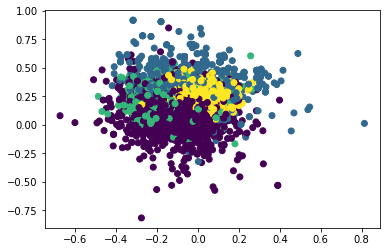

plot with true labels


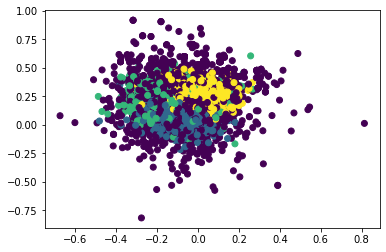

Glove : cah clustering on  original  data accuracy :  0.6346723044397463
Glove : cah clustering on  original  data NMI :  0.6561369557285788
Glove : cah clustering on  original  data ARI :  0.4463732019417088
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


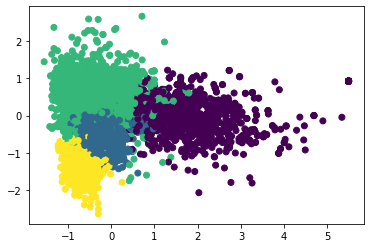

plot with true labels


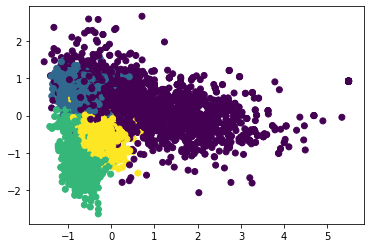

Glove : cah clustering on  PCA  data accuracy :  0.18449612403100776
Glove : cah clustering on  PCA  data NMI :  0.5927442265353383
Glove : cah clustering on  PCA  data ARI :  0.40823616477619545
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


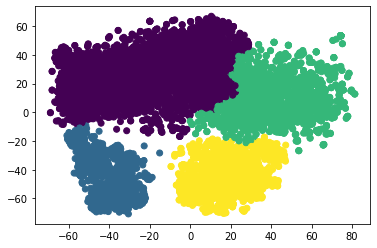

plot with true labels


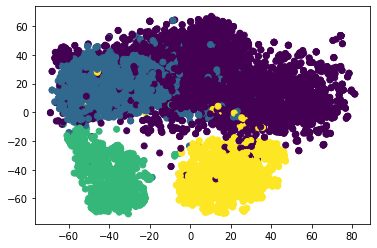

Glove : cah clustering on  TSNE  data accuracy :  0.42353770260747003
Glove : cah clustering on  TSNE  data NMI :  0.6952926608131008
Glove : cah clustering on  TSNE  data ARI :  0.5032983120277071
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


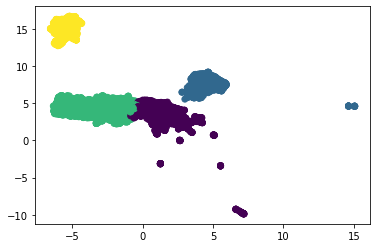

plot with true labels


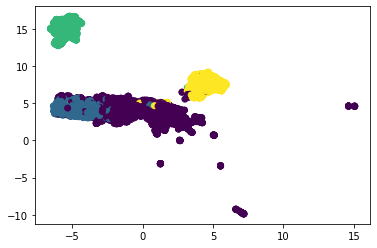

Glove : cah clustering on  UMAP  data accuracy :  0.21479915433403807
Glove : cah clustering on  UMAP  data NMI :  0.691238212385251
Glove : cah clustering on  UMAP  data ARI :  0.5004357807031206
________________________________________________________________________________________________________


In [24]:
def cah_runner(key,K,true_labels):
  y_pred = AgglomerativeClustering(n_clusters = K).fit_predict(reduced_data[key])
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : cah clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : cah clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : cah clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  cah_runner(a,K,true_labels)

# **BERT :**

In [9]:
#!pip install -U sentence-transformers

In [8]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [9]:
sentence_embedding = model.encode(abstract)

In [10]:
sentence_embedding.shape

(7095, 768)

In [28]:
pca = PCA(n_components=10)
result = pca.fit_transform(sentence_embedding)

In [29]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=5).fit(result)
y_pred = kmeans.labels_
labels_all, u  = pd.factorize(df["label"])
print('Bert Kmeans clustering  accuracy : ',accuracy_score(labels_all,y_pred))

Bert Kmeans clustering  accuracy :  0.546723044397463


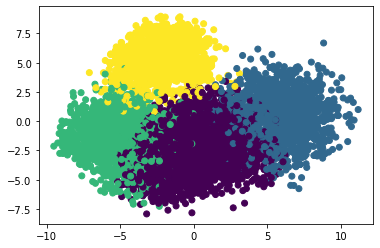

In [30]:
PCA_components = pd.DataFrame(result)
labels = y_pred
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

# **RoBerta :**

In [11]:
model = SentenceTransformer('sentence-transformers/roberta-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
sentence_embedding = model.encode(abstract) #prend bcp de temps +30mn !!

In [ ]:
pca = PCA(n_components=10)
result = pca.fit_transform(sentence_embedding)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=5).fit(result)
y_pred = kmeans.labels_
labels_all, u  = pd.factorize(df["label"])
print('RoBert Kmeans clustering  accuracy : ',accuracy_score(labels_all,y_pred))

In [ ]:
PCA_components = pd.DataFrame(result)
labels = y_pred
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()